<a href="https://colab.research.google.com/github/faiz-aljohani/Arabic-App-Review-Classification/blob/main/ICS472_NLP_Arabic_App_Review_Classification(1_Label).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part-B [65 points]:
 Multiclass and Multilabel App Review Classification

## Setup & Load Dataset

In [1]:
!pip install gensim
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras import layers, losses, optimizers, metrics

import keras_tuner

from gensim.models import Word2Vec

import nltk
from nltk import tokenize

import json

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
dataset = pd.read_csv("https://raw.githubusercontent.com/faiz-aljohani/Arabic-App-Review-Classification/main/AppReview-Multilabel.csv")

In [4]:
dataset

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,High,Medium,Low,No
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,No,Medium,Medium,Low
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,No,High,Low,No
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,No,No,High,No
4,تبين م لي ي تم ل يب,No,No,Low,High
...,...,...,...,...,...
2895,بكل حياديه وتجرد انقل تجربتي التطبيق جميل جدا ...,Medium,Medium,Medium,No
2896,مررة صار معفن مدري الا بالقوة بيدخلنا موقعهم ه...,Medium,No,Medium,No
2897,لابد من تطويره ليستفاد منو الجميع,No,High,Low,No
2898,تطبيق اكثر من رائع ومجهود مبارك ،ننتظر المزيد ...,No,Low,High,No


## Split the dataset train/val/test...
70-30 Train TestVal. Take 50% of TestVal data as validation set.
Use seed 777 for partitioning.

### binary labels

In [5]:
def string2number(val):
    mapping = {'High': 3, 'Medium': 2, 'Low': 1, 'No': 0}
    return mapping[val]


def pies_plot(columns, dataset):
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    for i, column in enumerate(columns):
        ax = axes[i // 2, i % 2]
        ax.set_title(column)
        ax.pie(dataset[column].value_counts(), labels=dataset[column].unique().tolist(), autopct='%1.1f%%')
    plt.tight_layout()
    plt.show()

In [6]:
columns_to_convert = ['bug_report', 'improvement_request', 'rating', 'others']
for column in columns_to_convert:
    dataset[column] = dataset[column].apply(string2number)

In [7]:
dataset.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,3,2,1,0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,2,2,1
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,3,1,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,3,0
4,تبين م لي ي تم ل يب,0,0,1,3


In [8]:
np.random.seed(777)

for index, row in dataset.iterrows():
    max_val = max(row[1:])
    max_indices = [i for i, val in enumerate(row[1:], start=1) if val == max_val]
    selected = np.random.choice(max_indices)
    for i, column in enumerate(dataset.columns[1:], start=1):
        if i == selected:
            dataset.at[index, column] = 1
        else:
            dataset.at[index, column] = 0

In [9]:
dataset.head()

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,1,0,0,0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,0,1,0
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,0,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0
4,تبين م لي ي تم ل يب,0,0,0,1


In [10]:
X = dataset.iloc[:,0].to_numpy()
y = dataset.iloc[:,1:].to_numpy()

In [11]:
train_sentences, testval_sentences, train_labels, testval_labels = train_test_split(X, y, test_size=0.3, random_state=777)
val_sentences, test_sentences, val_labels, test_labels = train_test_split(testval_sentences, testval_labels, test_size=0.5, random_state=777)

## Dataset analysis and report on important statistics.


In [12]:
display(dataset['bug_report'].value_counts())
display(dataset['improvement_request'].value_counts())
display(dataset['rating'].value_counts())
display(dataset['others'].value_counts())

bug_report
0    2171
1     729
Name: count, dtype: int64

improvement_request
0    2444
1     456
Name: count, dtype: int64

rating
0    1623
1    1277
Name: count, dtype: int64

others
0    2462
1     438
Name: count, dtype: int64

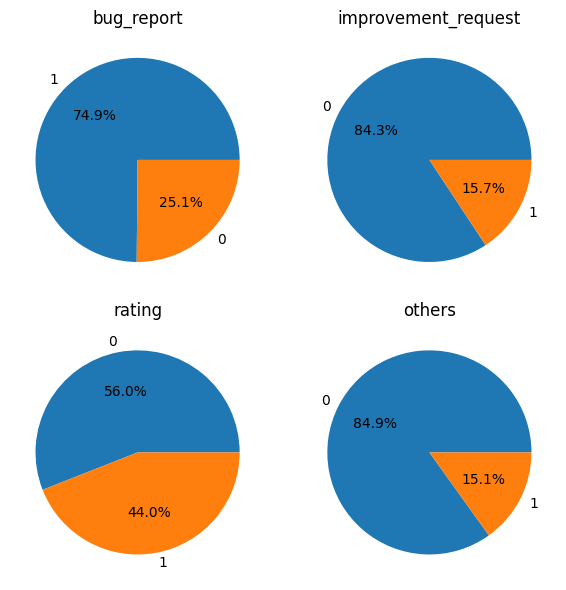

In [13]:
columns = ['bug_report', 'improvement_request', 'rating', 'others']
pies_plot(columns, dataset)

1. character count
2. word count
3. max sentence's character and word count
4. mean word length
5. mean sentence length

In [14]:
dataset['char_count'] = dataset['review'].str.len()
dataset['word_count'] = dataset['review'].str.split().str.len()
display(dataset.head())

,review,bug_report,improvement_request,rating,others,char_count,word_count
0,يبيله تصليحات كثير,1,0,0,0,18,3
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,0,1,0,33,6
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,0,0,76,13
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,45,8
4,تبين م لي ي تم ل يب,0,0,0,1,19,7


In [15]:
sortedDataset = dataset.sort_values('char_count', ascending=False)

sortedDataset.head()

,review,bug_report,improvement_request,rating,others,char_count,word_count
902,من فضلك أعد المحاولة\nمن فضلك أعد المحاولة\nمن...,0,0,0,1,3023,576
87,أكثر من مليار تحميل.... لكن فيه عيوب العيب الأ...,0,0,1,0,500,89
369,العبة جميلة جدا جدا جداجدا جديد جدا حمام الدار...,0,0,0,1,500,100
170,غير متقولوش لعائشة اذا كان علابالي راح نبعتلكم...,0,0,0,1,500,100
1562,جميل جداً ورائع لكن احس في بعض العيوب الليالي ...,0,0,0,1,499,93


In [16]:
dataset['mean_word_length'] = dataset['review'].map(lambda r: np.mean([len(word) for word in r.split()]))
dataset['mean_sent_length'] = dataset['review'].map(lambda r: np.mean([len(sent) for sent in tokenize.sent_tokenize(r)]))
dataset.head()

,review,bug_report,improvement_request,rating,others,char_count,word_count,mean_word_length,mean_sent_length
0,يبيله تصليحات كثير,1,0,0,0,18,3,5.333333,18.0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,0,1,0,33,6,4.666667,33.0
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,0,0,76,13,4.923077,76.0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0,45,8,4.750000,45.0
4,تبين م لي ي تم ل يب,0,0,0,1,19,7,1.857143,19.0


# Preprocessing

In [17]:
import re

sample = [
    'ماتحملت ابدددددا ونا دفعت الفلوس',
    'ألسلام عليكم في الناس كلب',
    'الََعبة جميلة جدا جدا جداجدا جديد جدا حمام الدار...',
    'ييييي السال',
    'ااا لللل ععع',
    'مما ننا ككا',
    'اللعبة'
]

def custom_preprocessing(sentences):
  sentences_proccesed = []
  for sentence in sentences:
    # Delete جميع الحركات
    sentence = re.sub(r'[\u064B-\u0652]', '', sentence)

    # Delete تحويل (أ, إ) الى ا
    sentence = re.sub(r'[أإ]', 'ا', sentence)

    # Delete حروف الجر, كان واخواتها
    sentence = re.sub(r'\b(فى|في|على|من|الى|كان|لكن)\b', ' ', sentence)

    # Replace ة الى ه
    sentence = re.sub(r'ة', r'ه', sentence)

    # Delete التعريف
    sentence = re.sub(r'\bال', '', sentence)

    # Delete الحرف المكرر اكثر من مرتين بالتوالي
    sentence = re.sub(r'(.)\1{2,}', r'\1\1', sentence)

    # Replace كل حرف يتكرر مرتين الى حرف واحد ما عدا الميم
    sentence = re.sub(r'(?!م|ن)(.)\1', r'\1', sentence)

    # Delete اي حرف لحاله
    sentence = re.sub(r'\b\w\b', '', sentence)

    # Delete اي كلمة اطول من 16 حرف
    sentence = ' '.join(word for word in sentence.split() if len(word) <= 16)

    # Delete اي علامة تتكرر مره وحده بس
    sentence = re.sub(r'([^\w\s])\1', '', sentence)

    sentences_proccesed.append(sentence)

  return sentences_proccesed

processed_samples = custom_preprocessing(sample)
print(processed_samples)

['ماتحملت ابدا ونا دفعت فلوس', 'سلام عليكم ناس كلب', 'عبه جميله جدا جدا جداجدا جديد جدا حمام دار.', 'سال', '', 'مما ننا كا', 'لعبه']


In [18]:
df = pd.DataFrame({'Original Sentences': train_sentences, 'Processed Sentences': custom_preprocessing(train_sentences)})

df['proccesed word count'] = df['Processed Sentences'].str.split().apply(len)
df['word count'] = df['Original Sentences'].str.split().apply(len)

df = df.sort_values(by='proccesed word count', ascending=False)

In [19]:
display(df.head(10))

,Original Sentences,Processed Sentences,proccesed word count,word count
1363,من فضلك أعد المحاولة\nمن فضلك أعد المحاولة\nمن...,فضلك اعد محاوله فضلك اعد محاوله فضلك اعد محاول...,432,576
1683,انا كويس الحمد والشكر على كل شيء شي من برا بس ...,انا كويس حمد والشكر كل شيء شي برا بس مو كل شي ...,95,106
192,غير متقولوش لعائشة اذا كان علابالي راح نبعتلكم...,غير متقولوش لعائشه اذا علابالي راح نبعتلكم تصو...,86,100
83,بكل حياديه وتجرد انقل تجربتي التطبيق جميل جدا ...,بكل حياديه وتجرد انقل تجربتي تطبيق جميل جدا جد...,85,92
85,جميل جداً ورائع لكن احس في بعض العيوب الليالي ...,جميل جدا ورائع احس بعض عيوب ليالي بيعلق معي كث...,84,93
289,كل ما افتح مقطع يوتيوب يطلع اعلان\nكل ما افتح ...,كل ما افتح مقطع يوتيوب يطلع اعلان كل ما افتح م...,81,84
924,نصابين ، لاحدا يشتري من المتجر ، بالآخر خسران ...,نصابين ، لاحدا يشتري متجر ، بالآخر خسران قد ما...,79,85
1591,العبة جميلة جدا جدا جداجدا جديد جدا حمام الدار...,عبه جميله جدا جدا جداجدا جديد جدا حمام دار اور...,78,100
1953,والله فرحنا كثيراً بتطبيق مطبعة الملك فهد لكن ...,واله فرحنا كثيرا بتطبيق مطبعه ملك فهد لاسف به ...,77,92
1302,اعزائي الزملاء : بما اني احد منسوبي الصحة ، فه...,اعزائي زملاء : بما اني احد منسوبي صحه ، فهذا ت...,73,76


## Tokenizing

In [20]:
def word_tokenize(docs):
  return [nltk.word_tokenize(doc) for doc in docs]

train_sentences_tokenized = word_tokenize(custom_preprocessing(train_sentences))
val_sentences_tokenized = word_tokenize(custom_preprocessing(val_sentences))
test_sentences_tokenized = word_tokenize(custom_preprocessing(test_sentences))

In [21]:
vocab = set([word for sublist in train_sentences_tokenized for word in sublist])
print(" Number of unique vocab: ", len(vocab))

 Number of unique vocab:  7862


9324 unique vocab without pre-processing

# Models : (Random method will have 6.25%)

## scrach model

### Encoding

In [22]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_sentences_tokenized)
train_sentences_encoded = word_tokenizer.texts_to_sequences(train_sentences_tokenized)

In [23]:
val_word_encoded = word_tokenizer.texts_to_sequences(val_sentences_tokenized)

In [24]:
test_word_encoded = word_tokenizer.texts_to_sequences(test_sentences_tokenized)

In [25]:
MAX_SEQ_LENGTH = max([len(seq) for seq in train_sentences_encoded])
print("Max sequence's length: ", MAX_SEQ_LENGTH)
train_sentences_padded = pad_sequences(train_sentences_encoded, maxlen=MAX_SEQ_LENGTH, padding='post')
val_sentences_padded = pad_sequences(val_word_encoded, maxlen=MAX_SEQ_LENGTH, padding='post')
test_sentences_padded = pad_sequences(test_word_encoded, maxlen=MAX_SEQ_LENGTH, padding='post')

Max sequence's length:  432


In [26]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32), axis=0)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32), axis=0)
    actual_positives = tf.reduce_sum(tf.cast(y_true, tf.float32), axis=0)

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

### Build model


In [70]:
def build_scrach_model(MAX_SEQ_LENGTH, vocab_size, embedding_dim):
    model = keras.Sequential()

    model.add(layers.Embedding(input_length=MAX_SEQ_LENGTH, input_dim=vocab_size, output_dim=embedding_dim))

    model.add(layers.Bidirectional(layers.LSTM(512)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4, activation="softmax"))

    return model

In [71]:
embedding_dim = 300
vocab_size = len(vocab) + 1
model = build_scrach_model(MAX_SEQ_LENGTH, vocab_size, embedding_dim)

In [72]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[f1_score]
  )

### Training


In [73]:
modelCheckpoint = keras.callbacks.ModelCheckpoint("/content/Best_scrach_model.h5",)

In [74]:
EPOCHS = 20
BATCH_SIZE = 16

model.fit(
  train_sentences_padded, train_labels,
  validation_data=(val_sentences_padded,val_labels),
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  callbacks=[modelCheckpoint]
)

Epoch 1/20
127/127 [==============================] - 24s 157ms/step - loss: 0.4916 - f1_score: 0.1976 - val_loss: 0.4155 - val_f1_score: 0.3200
Epoch 2/20
127/127 [==============================] - 16s 124ms/step - loss: 0.3266 - f1_score: 0.5668 - val_loss: 0.3843 - val_f1_score: 0.4687
Epoch 3/20
127/127 [==============================] - 14s 113ms/step - loss: 0.1418 - f1_score: 0.8465 - val_loss: 0.4205 - val_f1_score: 0.5472
Epoch 4/20
127/127 [==============================] - 14s 111ms/step - loss: 0.0623 - f1_score: 0.9235 - val_loss: 0.5431 - val_f1_score: 0.5107
Epoch 5/20
127/127 [==============================] - 14s 112ms/step - loss: 0.0356 - f1_score: 0.9367 - val_loss: 0.5773 - val_f1_score: 0.5076
Epoch 6/20
127/127 [==============================] - 14s 112ms/step - loss: 0.0126 - f1_score: 0.9655 - val_loss: 0.6646 - val_f1_score: 0.4852
Epoch 7/20
127/127 [==============================] - 14s 109ms/step - loss: 0.0136 - f1_score: 0.9542 - val_loss: 0.6830 - val_f1

### Evaluation

#### Validation

In [75]:
model.evaluate(val_sentences_padded, val_labels)

14/14 [==============================] - 1s 54ms/step - loss: 0.9528 - f1_score: 0.4980


[0.952839195728302, 0.4979967176914215]

#### Test

In [76]:
model.evaluate(test_sentences_padded, test_labels)

14/14 [==============================] - 1s 49ms/step - loss: 0.9756 - f1_score: 0.5072


[0.97557133436203, 0.5072011351585388]

#### Show random sample

In [87]:
import random
prediction = model.predict(val_sentences_padded)
threshold = 0.5
predicted_labels = (prediction > threshold).astype(int)

i = random.randint(0, len(prediction) - 1)

print(f"idx: {i}")
print("Sentence: ", test_sentences[i])
print("Preprocessed Sentence: ",custom_preprocessing([test_sentences[i]]))
print("Prediction:   ", predicted_labels[i])
print("Ground Truth: ", test_labels[i])


print("Matche:   ", predicted_labels[i] == test_labels[i])

14/14 [==============================] - 1s 57ms/step
idx: 367
Sentence:  العبه كويسه بس الحصول عل موارد صعد جدا وارجو حل مشكله العدوان على القاعده
Preprocessed Sentence:  ['عبه كويسه بس حصول عل موارد صعد جدا وارجو حل مشكله عدوان قاعده']
Prediction:    [0 0 1 0]
Ground Truth:  [0 0 1 0]
Matche:    [ True  True  True  True]


#### Try on sample

In [88]:
sample = ['اللعبة  خايسه ويبيلها تطوير']
sample_processed = custom_preprocessing(sample)
sample_processed_tokenized = word_tokenize(sample_processed)
sample_sentences_encoded = word_tokenizer.texts_to_sequences(sample_processed_tokenized)
sample_processed_padded = pad_sequences(sample_sentences_encoded, maxlen=MAX_SEQ_LENGTH, padding='post')

sample_prediction_label = model.predict(sample_processed_padded)
sample_prediction_label = (sample_prediction_label > threshold).astype(int)
print(sample)
print(sample_processed)
print(sample_prediction_label)

1/1 [==============================] - 0s 27ms/step
['اللعبة  خايسه ويبيلها تطوير']
['لعبه خايسه ويبيلها تطوير']
[[0 0 1 0]]


### Hyperparameter Tuning

In [91]:
def build(embedding_dim, units, useDropout, optimizer):
    model = keras.Sequential()

    model.add(layers.Embedding(
        input_length=MAX_SEQ_LENGTH,
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    model.add(layers.Bidirectional(layers.LSTM(units)))

    if useDropout:
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4, activation="softmax"))

    return model

In [92]:
vocab_size = len(vocab) + 1

list_embedding_dim = [200, 300]
list_units = [128, 256]
useDropout = [True, False]
list_optimizers = ['adam', 'rmsprop', 'sgd']
best_eval_score = float('-inf')
best_tuned_model = None
dictionary = {}

total_iterations = len(list_embedding_dim) * len(list_units) * len(useDropout) * len(list_optimizers)
for i, (embedding_dim, units, dropout, optimizer) in enumerate(itertools.product(list_embedding_dim, list_units, useDropout, list_optimizers)):

    print(f"Iteration:{total_iterations}/{i+1}, embedding_dim:{embedding_dim}, units:{units}, dropout:{dropout}, optimizer:{optimizer}")

    model = build(embedding_dim, units, dropout, optimizer)
    model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=[f1_score],
        )

    history = model.fit(train_sentences_padded, train_labels, epochs=3, batch_size=64, validation_data=(val_sentences_padded, val_labels))
    eval_score = history.history['val_f1_score'][0]

    dictionary[(embedding_dim, units, dropout, optimizer)] = {'eval_score': eval_score}

    if eval_score > best_eval_score:
      best_eval_score = eval_score
      best_model = model

Iteration:24/1, embedding_dim:200, units:128, dropout:True, optimizer:adam
Epoch 1/3
32/32 [==============================] - 23s 360ms/step - loss: 1.2925 - f1_score: 0.0206 - val_loss: 1.1645 - val_f1_score: 0.1423
Epoch 2/3
32/32 [==============================] - 8s 249ms/step - loss: 0.8912 - f1_score: 0.3247 - val_loss: 0.9482 - val_f1_score: 0.3832
Epoch 3/3
32/32 [==============================] - 6s 188ms/step - loss: 0.4335 - f1_score: 0.7142 - val_loss: 0.9932 - val_f1_score: 0.5224
Iteration:24/2, embedding_dim:200, units:128, dropout:True, optimizer:rmsprop
Epoch 1/3
32/32 [==============================] - 16s 279ms/step - loss: 1.2880 - f1_score: 0.0293 - val_loss: 1.2004 - val_f1_score: 0.0604
Epoch 2/3
32/32 [==============================] - 5s 157ms/step - loss: 1.0810 - f1_score: 0.2012 - val_loss: 1.0284 - val_f1_score: 0.2877
Epoch 3/3
32/32 [==============================] - 6s 180ms/step - loss: 0.8325 - f1_score: 0.3717 - val_loss: 0.9274 - val_f1_score: 0.3748

In [93]:
new_dictionary = {str(key): {'eval_score': value['eval_score']} for key, value in dictionary.items()}
new_dictionary = {str(key): value for key, value in new_dictionary.items()}
file_path = "/content/Hyperparameter_scrach_models.json"

# Write the dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(new_dictionary, json_file)

print("Dictionary stored in:", file_path)

Dictionary stored in: /content/Hyperparameter_scrach_models.json


In [104]:
file_path = "/content/Hyperparameter_scrach_models.json"

# Read the dictionary from the JSON file
with open(file_path, 'r') as json_file:
    hyperparameter_scrach_models = json.load(json_file)

In [105]:
df = pd.DataFrame.from_dict(hyperparameter_scrach_models, orient='index')

df_sorted = df.sort_values(by='eval_score', ascending=False)

display(df_sorted)

,eval_score
"(300, 256, False, 'adam')",0.340210
"(200, 256, False, 'adam')",0.307731
"(300, 256, True, 'adam')",0.300952
"(300, 128, False, 'adam')",0.284978
"(200, 128, False, 'adam')",0.205390
"(200, 256, True, 'adam')",0.173196
"(300, 128, True, 'adam')",0.171214
"(300, 256, False, 'rmsprop')",0.169635
"(200, 256, True, 'rmsprop')",0.160972
"(300, 128, False, 'rmsprop')",0.153041


#### Build model

In [109]:
def build_hyperparameter_tuning(embedding_dim= 300, units=256 , useDropout=False):
    model = keras.Sequential()

    model.add(layers.Embedding(
        input_length=MAX_SEQ_LENGTH,
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True
    ))

    model.add(layers.Bidirectional(layers.LSTM(units)))

    if useDropout:
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4, activation="softmax"))

    return model

In [111]:
model_hyperparameter_tuning = build_hyperparameter_tuning()

In [112]:
model_hyperparameter_tuning.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[f1_score]
  )

#### Training

In [113]:
EPOCHS = 20
BATCH_SIZE = 16

model_hyperparameter_tuning.fit(
  train_sentences_padded, train_labels,
  validation_data=(val_sentences_padded,val_labels),
  epochs=EPOCHS,
  batch_size=BATCH_SIZE,
  callbacks=[modelCheckpoint]
)

Epoch 1/20
127/127 [==============================] - ETA: 0s - loss: 0.4809 - f1_score: 0.2265

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 30s 160ms/step - loss: 0.4809 - f1_score: 0.2265 - val_loss: 0.4087 - val_f1_score: 0.3416
Epoch 2/20
127/127 [==============================] - 9s 66ms/step - loss: 0.2715 - f1_score: 0.6341 - val_loss: 0.3769 - val_f1_score: 0.5103
Epoch 3/20
127/127 [==============================] - 8s 65ms/step - loss: 0.1084 - f1_score: 0.8656 - val_loss: 0.4524 - val_f1_score: 0.5076
Epoch 4/20
127/127 [==============================] - 10s 77ms/step - loss: 0.0635 - f1_score: 0.9189 - val_loss: 0.5633 - val_f1_score: 0.4919
Epoch 5/20
127/127 [==============================] - 5s 42ms/step - loss: 0.0327 - f1_score: 0.9356 - val_loss: 0.6099 - val_f1_score: 0.4979
Epoch 6/20
127/127 [==============================] - 9s 70ms/step - loss: 0.0214 - f1_score: 0.9235 - val_loss: 0.6641 - val_f1_score: 0.4825
Epoch 7/20
127/127 [==============================] - 6s 49ms/step - loss: 0.0057 - f1_score: 0.9609 - val_loss: 0.7361 - val_f1_score: 0.4663
Epoch 8

#### Evaluation

##### Validation


In [114]:
model_hyperparameter_tuning.evaluate(val_sentences_padded, val_labels)

14/14 [==============================] - 0s 7ms/step - loss: 1.0186 - f1_score: 0.5251


[1.0186113119125366, 0.5251091718673706]

##### Test

In [115]:
model_hyperparameter_tuning.evaluate(test_sentences_padded, test_labels)

14/14 [==============================] - 1s 35ms/step - loss: 0.9724 - f1_score: 0.5432


[0.97235506772995, 0.5431581139564514]

## model with pretrained embedding

### Encoding

In [ ]:
# word2vec_model = Word2Vec(train_sentences_tokenized, vector_size=100, window=5, min_count=1, workers=4)

# def preprocessing_train(data):
#   sentences = [[word2vec_model.wv.get_index(word) for word in words if word in word2vec_model.wv.index_to_key] for words in data]
#   MAX_SEQ_LENGTH = max(len(seq) for seq in sentences)
#   sentences_padded = np.array([seq + [0]*(MAX_SEQ_LENGTH - len(seq)) for seq in sentences])
#   return sentences_padded, MAX_SEQ_LENGTH

# def preprocessing_eval(data, MAX_SEQ_LENGTH):
#   sentences = [[word2vec_model.wv.get_index(word) for word in words if word in word2vec_model.wv.index_to_key] for words in data]
#   sentences_padded = np.array([seq + [0]*(MAX_SEQ_LENGTH - len(seq)) for seq in sentences])
#   return sentences_padded


# train_sentences_padded, MAX_SEQ_LENGTH = preprocessing_train(train_sentences_tokenized)
# val_sentences_padded = preprocessing_eval(val_sentences_tokenized, MAX_SEQ_LENGTH)
# test_sentences_padded = preprocessing_eval(val_sentences_tokenized, MAX_SEQ_LENGTH)

### Build model

In [ ]:
# def build_model(MAX_SEQ_LENGTH, embedding_dim):
#     model = keras.Sequential()

#     model.add(layers.Embedding(input_length=MAX_SEQ_LENGTH, input_dim=len(word2vec_model.wv.index_to_key), output_dim=embedding_dim, mask_zero=True))

#     model.add(layers.Bidirectional(layers.LSTM(512)))

#     model.add(layers.Dense(4, activation="sigmoid"))

#     return model

In [ ]:
# model = build_model(MAX_SEQ_LENGTH, embedding_dim)

In [ ]:
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

### Training


In [ ]:
# EPOCHS = 20
# BATCH_SIZE = 16

# model.fit(
#     train_sentences_padded, train_labels,
#     validation_data=(val_sentences_padded ,val_labels),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE
# )

### Evaluation

In [ ]:
# prediction = model.predict(test_sentences_padded)
# threshold = 0.5
# predicted_classes = (prediction > threshold).astype(int)
# accuracy = np.mean(predicted_classes == test_labels)

# print("Accuracy:", accuracy)

#### Validation

In [ ]:
# loss, accuracy = model.evaluate(test_sentences_padded, test_labels)

#### Test

In [ ]:
# loss, accuracy = model.evaluate(test_sentences_padded, test_labels)

# Active learning

### Build model

In [96]:
def build_activeLearning_model(MAX_SEQ_LENGTH, vocab_size, embedding_dim):
    model = keras.Sequential()

    model.add(layers.Embedding(input_length=MAX_SEQ_LENGTH, input_dim=vocab_size, output_dim=embedding_dim))

    model.add(layers.Bidirectional(layers.LSTM(512)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4, activation="softmax"))

    return model

### Training


In [97]:
initial_indices = np.random.choice(len(train_sentences_encoded), 50, replace=False)
remaining_indices = np.setdiff1d(np.arange(len(train_sentences_encoded)), initial_indices)

In [98]:
initial_train_sentences = train_sentences_padded[initial_indices]
initial_train_labels = train_labels[initial_indices]

In [99]:
EPOCHS = 10
BATCH_SIZE = 16
NUM_QUERIES = 5
QUERY_SIZE = 50

In [100]:
for i in range(NUM_QUERIES):
    print(f"Active Learning Iteration: {i+1}")

    model_entropy_activeLearning = build_activeLearning_model(MAX_SEQ_LENGTH, vocab_size, embedding_dim)
    model_entropy_activeLearning.compile(optimizer="adam", loss='categorical_crossentropy', metrics=[f1_score])
    model_entropy_activeLearning.fit(
        initial_train_sentences, initial_train_labels,
        validation_data=(val_sentences_padded, val_labels),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )

    remaining_sentences = train_sentences_padded[remaining_indices]
    predictions = model.predict(remaining_sentences)

    entropy = -np.sum(predictions * np.log(predictions + 1e-10), axis=1)

    query_indices = np.argsort(entropy)[-QUERY_SIZE:]
    selected_indices = remaining_indices[query_indices]

    initial_train_sentences = np.concatenate((initial_train_sentences, train_sentences_padded[selected_indices]))
    initial_train_labels = np.concatenate((initial_train_labels, train_labels[selected_indices]))

    remaining_indices = np.setdiff1d(remaining_indices, selected_indices)

model_entropy_activeLearning.save("/content/Best_entropy_active_learning_model.h5")

Active Learning Iteration: 1
Epoch 1/10
4/4 [==============================] - 7s 814ms/step - loss: 1.3114 - f1_score: 0.0609 - val_loss: 1.3054 - val_f1_score: 0.1529
Epoch 2/10
4/4 [==============================] - 2s 609ms/step - loss: 1.1918 - f1_score: 0.0778 - val_loss: 1.2800 - val_f1_score: 0.0020
Epoch 3/10
4/4 [==============================] - 2s 546ms/step - loss: 1.1757 - f1_score: 0.0000e+00 - val_loss: 1.2770 - val_f1_score: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 2s 673ms/step - loss: 1.1429 - f1_score: 0.0567 - val_loss: 1.2611 - val_f1_score: 0.1254
Epoch 5/10
4/4 [==============================] - 2s 582ms/step - loss: 1.0353 - f1_score: 0.1481 - val_loss: 1.2585 - val_f1_score: 0.1426
Epoch 6/10
4/4 [==============================] - 2s 498ms/step - loss: 0.9392 - f1_score: 0.2163 - val_loss: 1.4720 - val_f1_score: 0.1588
Epoch 7/10
4/4 [==============================] - 2s 607ms/step - loss: 0.8296 - f1_score: 0.3422 - val_loss: 1.2649 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluating

#### Validation

In [101]:
val_loss, val_f1 = model_entropy_activeLearning.evaluate(val_sentences_padded, val_labels)

14/14 [==============================] - 1s 48ms/step - loss: 1.6717 - f1_score: 0.3635


#### Test

In [102]:
test_loss, test_f1 = model_entropy_activeLearning.evaluate(test_sentences_padded, test_labels)

14/14 [==============================] - 1s 48ms/step - loss: 1.7289 - f1_score: 0.3805
